<a href="https://colab.research.google.com/github/geomyll33/Beautez/blob/master/LSTM_NOrmality_FUlley_Stationarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import datetime as dt
from datetime import datetime, date
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

The data is the measurements of water consumption in one household with a three month sampling rate over a period of almost 10 years. 

In [18]:
df=pd.read_csv('/content/ευδαπ_dataset_527085.csv')
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (81, 2)


,timestamp,indication
0,27-01-01,395
1,24-04-01,396
2,26-07-01,396
3,22-10-01,396
4,25-01-02,396


In [19]:
df['date'] = pd.to_datetime(df['timestamp'], format ='%d-%m-%y')
df['indication'] = pd.to_numeric(df['indication'], errors='coerce')
#df = df.dropna(subset=['indication'])
df['year'] = df['date'].apply(lambda x: x.year)
df['quarter'] = df['date'].apply(lambda x: x.quarter)
df['month'] = df['date'].apply(lambda x: x.month)
df['day'] = df['date'].apply(lambda x: x.day)
df=df.loc[:,['date','indication', 'year','quarter','month','day']]
df.sort_values('date', inplace=True, ascending=True)
df = df.reset_index(drop=True)
print(df.shape)
print(df.date.min())
print(df.date.max())
df.head(5)

(81, 6)
2001-01-27 00:00:00
2020-07-26 00:00:00


,date,indication,year,quarter,month,day
0,2001-01-27,395,2001,1,1,27
1,2001-04-24,396,2001,2,4,24
2,2001-07-26,396,2001,3,7,26
3,2001-10-22,396,2001,4,10,22
4,2002-01-25,396,2002,1,1,25


Statistical Normality Test
There are several statistical tests that we can use to quantify whether our data looks as though it was drawn from a Gaussian distribution. And we will use D’Agostino’s K^2 Test.

In the SciPy implementation of the test, we will interpret the p value as follows.

p <= alpha: reject H0, not normal.
p > alpha: fail to reject H0, normal.

In [20]:
stat, p = stats.normaltest(df.indication)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=28.393, p=0.000
Data does not look Gaussian (reject H0)


We can also calculate kurtosis and skewness, to determine if the data distribution departs from the normal distribution.

count    81.000
mean    432.642
std     160.258
min       0.000
25%     399.000
50%     470.000
75%     565.000
max     566.000
Name: indication, dtype: float64
Kurtosis of normal distribution: 1.6264388677029666
Skewness of normal distribution: -1.5683429978153862


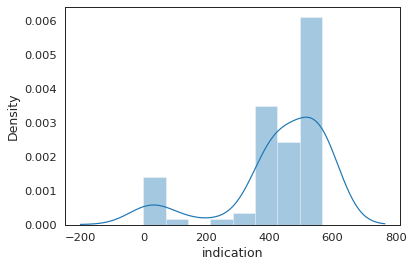

In [21]:

print(df.indication.describe())
sns.distplot(df.indication);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.indication)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.indication)))

KURTOSIS: describes heaviness of the tails of a distribution

Normal Distribution has a kurtosis of close to 0. If the kurtosis is greater than zero, then distribution has heavier tails. If the kurtosis is less than zero, then the distribution is light tails. And our Kurtosis is greater than zero.

SKEWNESS:

If the skewness is between -0.5 and 0.5, the data are fairly symmetrical. If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed. If the skewness is less than -1 or greater than 1, the data are highly skewed. And our skewness is greater than 1.

# **First Time series plot**

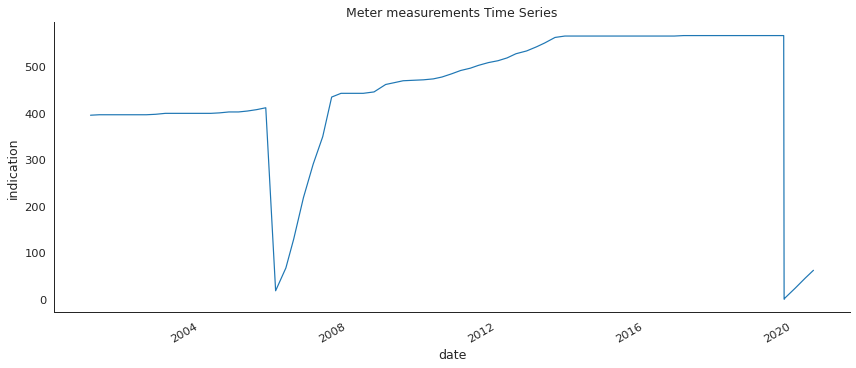

In [22]:
df1=df.loc[:,['date','indication']]
df1.set_index('date',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('indication')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Meter measurements Time Series')
sns.despine(top=True)
plt.show();

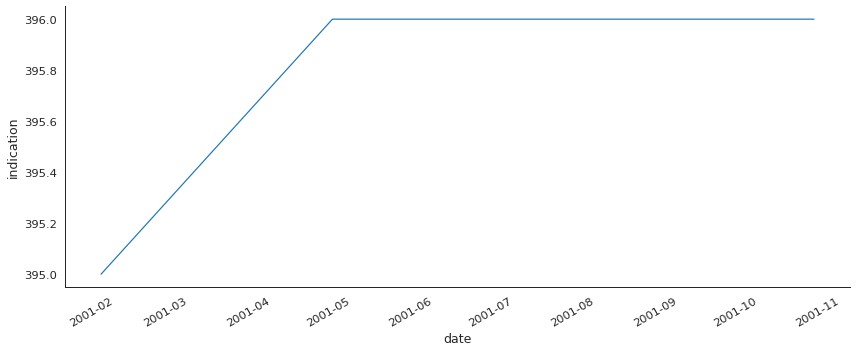

In [23]:

df2=df1[(df1.index>='2001-01-27') & (df1.index<'2001-12-27')]
df2.plot(figsize=(12,5));
plt.ylabel('indication')
plt.legend().set_visible(False)
plt.tight_layout()
sns.despine(top=True)
plt.show();

#Box plot of yearly vs. quarterly Global active power

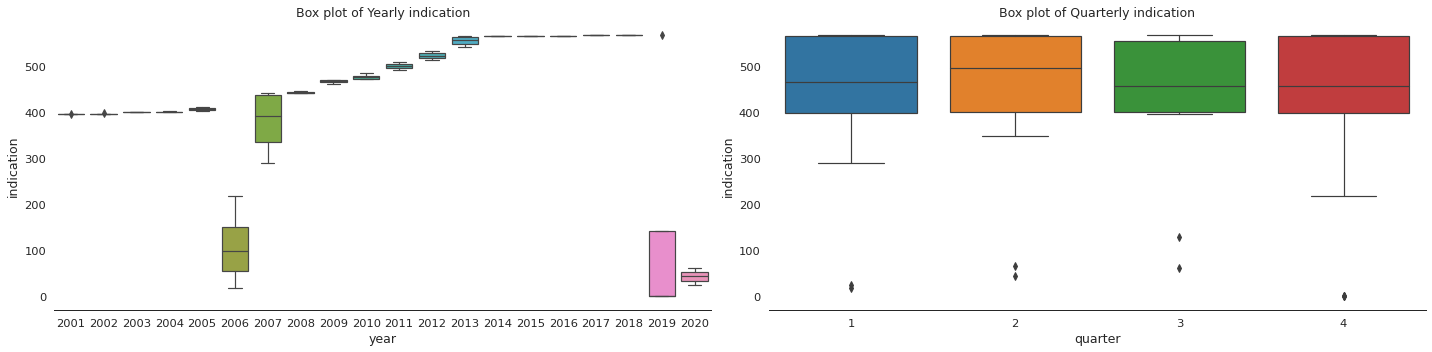

In [24]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="indication", data=df)
plt.xlabel('year')
plt.title('Box plot of Yearly indication')
sns.despine(left=True)
plt.tight_layout() 

plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="indication", data=df)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly indication')
sns.despine(left=True)
plt.tight_layout();

When we compare boxplot side by side for each year, we notice that the median indication in 2006,2007,2019 is much higher than the other years'. This is a little bit misleading. 

This is consistent with the quarterly median indication, it is almost equal to all seasons).


# Meter indication Distribution

,count,mean,std,min,25%,50%,75%,max
indication,81.000,432.642,160.258,0.000,399.000,470.000,565.000,566.000


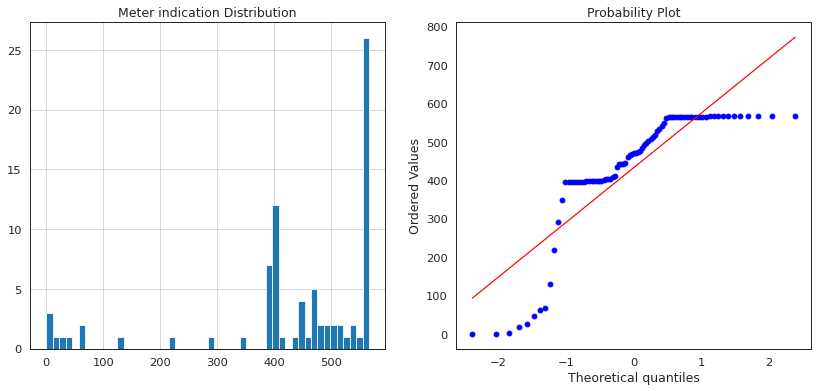

In [25]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['indication'].hist(bins=50)
plt.title('Meter indication Distribution')

plt.subplot(1,2,2)
stats.probplot(df['indication'], plot=plt);
df1.describe().T

Normal probability plot also shows the data set is far from normally distributed.

# Average Meter indication resampled over day, week, month, quarter and year.

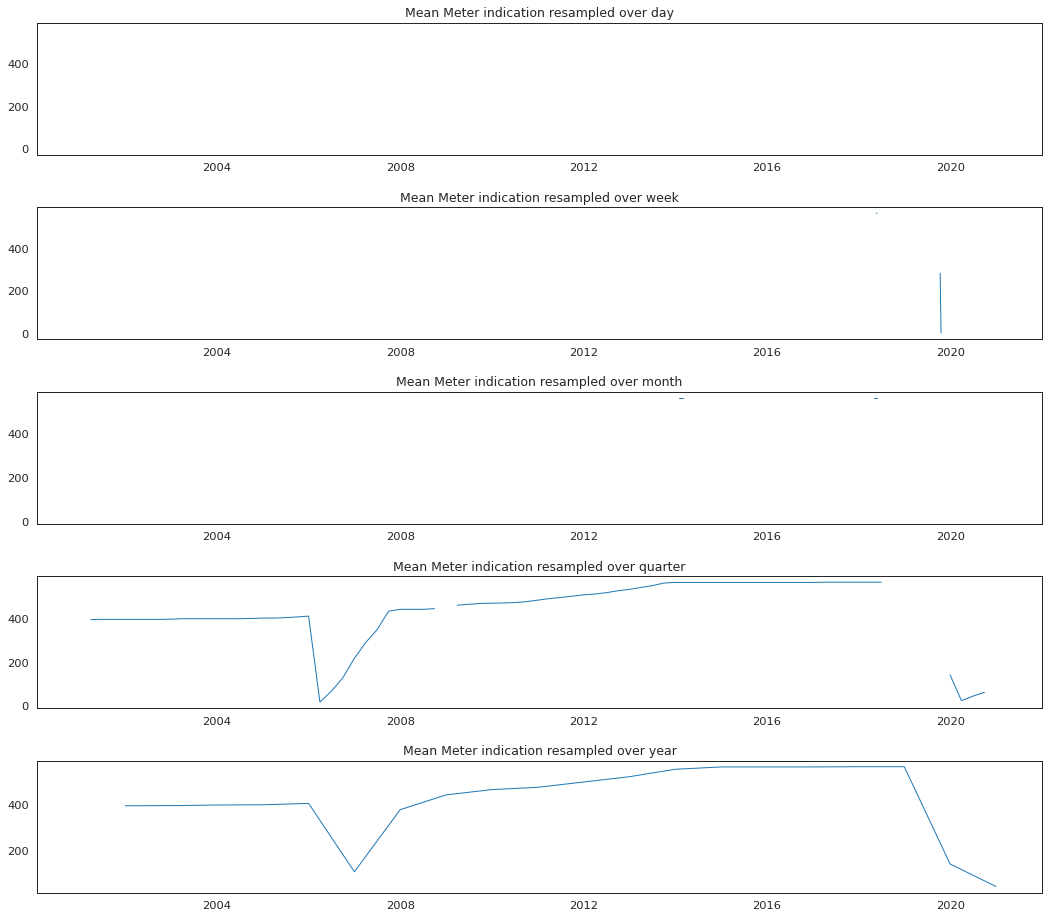

In [26]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['indication'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Meter indication resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['indication'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Meter indication resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['indication'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Meter indication resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1['indication'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Meter indication resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df1['indication'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Meter indication resampled over year')
ax5.tick_params(axis='both', which='major');

In general, our time series does not have a general upward or downward trend. The highest average power consumption was prior to 2020

# Global Active Power by Years

In [47]:
pd.pivot_table(df.loc[df['year']], values = "indication",columns = "year", index = "month").plot(subplots = True, figsize=(12, 12), layout=(3, 5),sharey=True);

KeyError: ignored

# Dickey-Fuller Test to Ceck Stationarity

In statistics, the Dickey–Fuller test tests the null hypothesis that a unit root is present in an autoregressive model. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

Stationary series has constant mean and variance over time. Rolling average and the rolling standard deviation of time series do not change over time.

Dickey-Fuller test
Null Hypothesis (H0): It suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): It suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary

In [45]:
df2=df1.resample('M').mean()

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

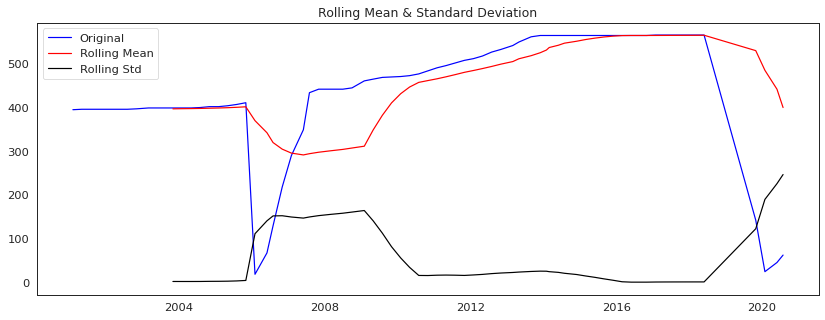

<Results of Dickey-Fuller Test>
Test Statistic                -2.016
p-value                        0.280
#Lags Used                     1.000
Number of Observations Used   73.000
Critical Value (1%)           -3.523
Critical Value (5%)           -2.902
Critical Value (10%)          -2.588
dtype: float64


In [46]:

test_stationarity(df2.indication.dropna())

From the above results, we will reject the null hypothesis H0, the data does not have a unit root and is stationary.

# LSTM

The task here will be to predict values for a timeseries given the history of 2 million minutes of a household's power consumption. We are going to use a multi-layered LSTM recurrent neural network to predict the last value of a sequence of values.

If you want to reduce the computation time, and also get a quick result to test the model, you may want to resample the data over hour. I will keep it is in minutes.

Create dataset, normalize the dataset, split into training and test sets, convert an array of values into a dataset matrix

In [172]:
dataset = df.indication.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [173]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [174]:

# reshape into X=t and Y=t+1
look_back = 10
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [175]:
X_train.shape

(53, 10)

In [176]:
Y_train.shape

(53,)

In [177]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Model Architecture

In [178]:
X_train.shape

(53, 1, 10)

In [179]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=120, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.8164 - val_loss: 0.1834
Epoch 2/20
1/1 [==============================] - 0s 40ms/step - loss: 0.7485 - val_loss: 0.1689
Epoch 3/20
1/1 [==============================] - 0s 38ms/step - loss: 0.6975 - val_loss: 0.1563
Epoch 4/20
1/1 [==============================] - 0s 36ms/step - loss: 0.6535 - val_loss: 0.1457
Epoch 5/20
1/1 [==============================] - 0s 36ms/step - loss: 0.6046 - val_loss: 0.1370
Epoch 6/20
1/1 [==============================] - 0s 36ms/step - loss: 0.5566 - val_loss: 0.1304
Epoch 7/20
1/1 [==============================] - 0s 42ms/step - loss: 0.5161 - val_loss: 0.1257
Epoch 8/20
1/1 [==============================] - 0s 35ms/step - loss: 0.4693 - val_loss: 0.1231
Epoch 9/20
1/1 [==============================] - 0s 38ms/step - loss: 0.4361 - val_loss: 0.1225
Epoch 10/20
1/1 [==============================] - 0s 36ms/step - loss: 0.4021 - val_loss: 0.1240
Epoch 11/20
1/1 [==============

In [180]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 187.51186627508932
Train Root Mean Squared Error: 193.0749808576976
Test Mean Absolute Error: 265.61657641265384
Test Root Mean Squared Error: 273.4122172856252


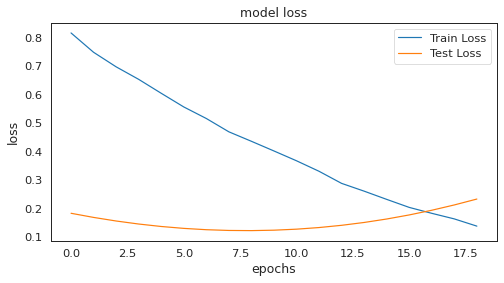

In [181]:

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

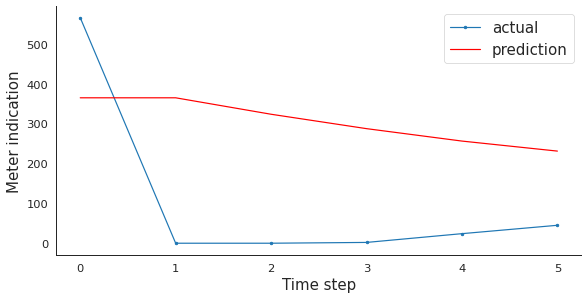

In [182]:
aa=[x for x in range(6)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:6], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:6], 'r', label="prediction")
plt.tick_params(left=False, labelleft=True) 
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Meter indication', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();